In [1]:
import numpy as np
import os
import geopandas as gpd
import pandas as pd
from scipy import stats as scipy_stats
import scipy.signal
import rasterio
import rasterio.features
from rasterio import MemoryFile
from affine import Affine
from rasterio.plot import show
from rasterio.plot import show_hist
import matplotlib.pyplot as plt
import rasterstats
from scipy.ndimage import gaussian_filter
from shapely.geometry import Polygon, shape, MultiPolygon
import shapely
import subprocess as sp

# Import libs
import sys
module_path = os.path.abspath(os.path.join('..', 'libs'))
if module_path not in sys.path:
    sys.path.append(module_path)
from s3utils import *

/Users/colinbrust/projects/rooftop-index/venv/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [40]:
S3R = S3Helper('roof-index')

# Read necessary_data
height = S3R.read_tif_from_s3_as_rio("missoula/geospatial/downtown_height.tif" ) 
flat = S3R.read_shp_from_s3_as_gpd("missoula/geospatial/contiguous_flat.zip").to_crs(6514)
bldgs = S3R.read_shp_from_s3_as_gpd('missoula/geospatial/downtown_bldgs.zip').to_crs(6514)

## Detect all interior polygons within a FAID

In [43]:
out = []
for geom in flat['geometry']:
    interior_coords = []
    for interior in geom.interiors:
        interior_coords.append(interior.coords)
    
    out.append(interior_coords)

interiors = []
for geom in out:
    interiors.append(MultiPolygon([Polygon(geom[i]) for i, _ in enumerate(geom)]))    

# Create GDF of interior polygons
interiors = pd.DataFrame({'flat_id': flat['flat_id'], 'geometry': interiors})
interiors = gpd.GeoDataFrame(interiors)
interiors = interiors.drop_duplicates()

## Convert all MultiPolygons into individual Polygons so we can get height of each one

In [44]:
# Taken from https://gist.github.com/mhweber/cf36bb4e09df9deee5eb54dc6be74d26
def explode(indf):
    outdf = gpd.GeoDataFrame(columns=indf.columns)
    for idx, row in indf.iterrows():
        if type(row.geometry) == Polygon:
            outdf = outdf.append(row,ignore_index=True)
        if type(row.geometry) == MultiPolygon:
            multdf = gpd.GeoDataFrame(columns=indf.columns)
            recs = len(row.geometry)
            multdf = multdf.append([row]*recs,ignore_index=True)
            for geom in range(recs):
                multdf.loc[geom,'geometry'] = row.geometry[geom]
            outdf = outdf.append(multdf,ignore_index=True)
    return outdf

interiors = explode(interiors)

## Add Building Height Column

In [45]:
def calc_height(shp, raster, column_name='bldg_height'): 

    zstats = rasterstats.zonal_stats(shp, raster.read(1), affine=raster.transform,
        nodata=raster.nodata, geojson_out=True, stats="median")

    bh = []
    for b in zstats:
        bh_temp = (b['properties']['flat_id'], b['properties']['median'])
        bh.append(bh_temp)

    bh_df = gpd.GeoDataFrame(bh, columns=['flat_id', column_name])
    full_data = pd.merge(shp, bh_df)
    full_data[column_name] = full_data[column_name] * 3.28084
    return full_data     

interiors = calc_height(interiors, height, 'interior_height')
flat = calc_height(flat, height, 'faid_height')

In [63]:
interiors['interior_area'] = interiors['geometry'].area * 10.7639
merged = pd.merge(interiors.drop(columns='geometry'), flat, on='flat_id')
merged['rise'] = merged['interior_height'] - merged['faid_height']
merged['rise'] = [0 if x < 0 else x for x in merged['rise']]
merged['volume'] = merged['rise'] * merged['interior_area']
test = merged[['flat_id', 'volume', 'geometry']]
output = test.dissolve(by='flat_id', aggfunc='sum')

<AxesSubplot:>

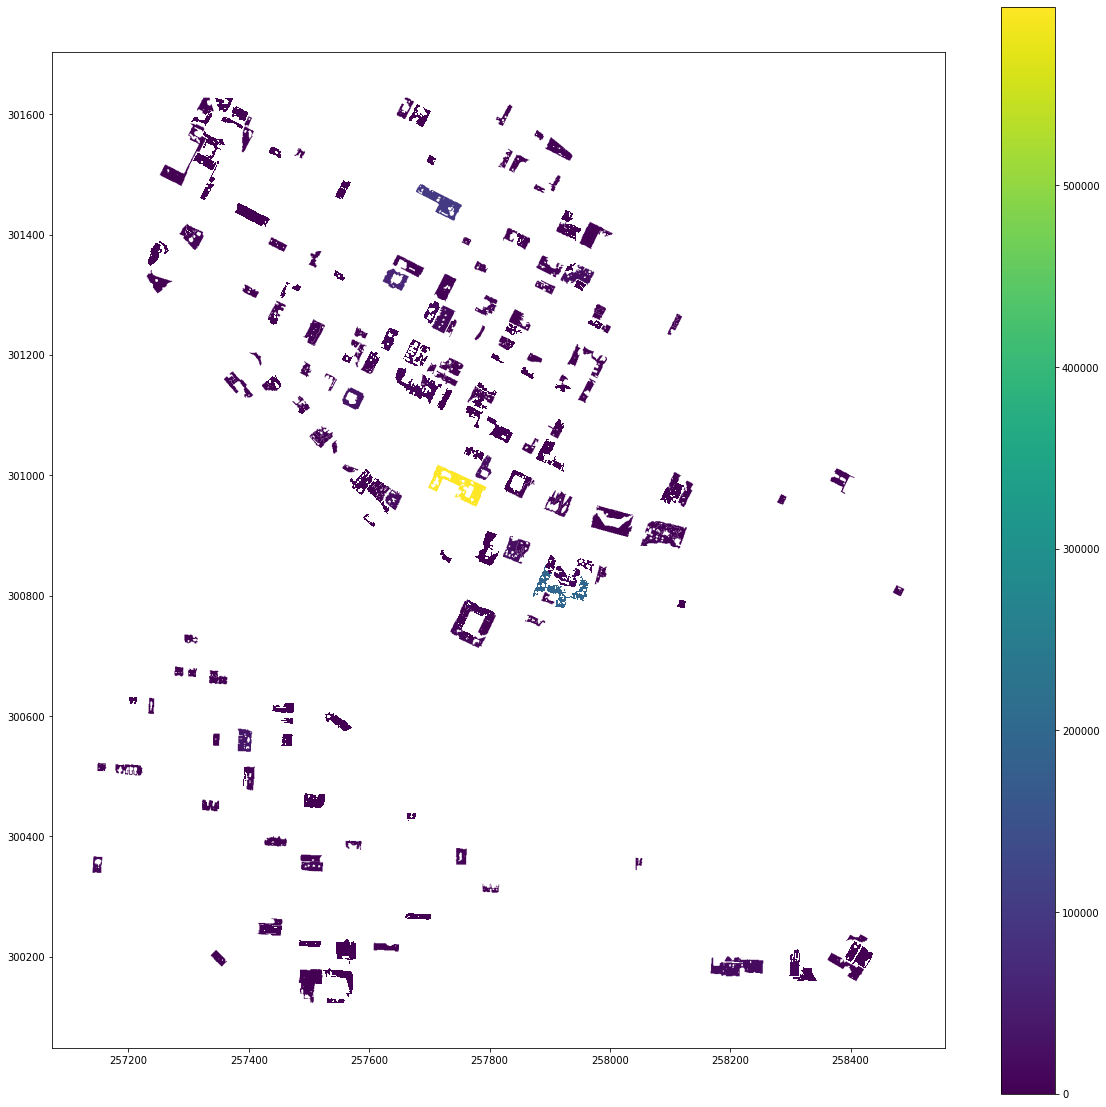

In [64]:
fig, ax = plt.subplots(1,1, figsize=(20,20))
output.plot(column='volume', legend=True, ax=ax)